In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import GradScaler, autocast
import tensorflow as tf
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,10)})

In [26]:
# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

print(train_data.head())

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

def model_summary(model):
    print("Model summary:")
    print("---------------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
    print(f"Total parameters: {total_params}")

                       id                                             lyrics  \
0  1FAmKoufyAXMfzPPs9bsjA  i tied my bandana took my pack from the floor ...   
1  3QvPEv8XjHa73iYhaienWw  i want to live on the moon never see a human a...   
2  5VPFATm85G3P04Q5g8yxqr  bitch you know you can t parallel park anyway ...   
3  7J2jCftItt7htcOUdcMnpt  graceless falling slipping in the cold with no...   
4  4cBPzVIbDIQx0LIyauFAy0  madame morse estate stood five hundred years p...   

       artist_name most_common_genre  \
0  Waylon Jennings           country   
1   Phantom Planet              rock   
2    Isaiah Rashad           hip-hop   
3     Matt Pond PA             indie   
4       Ariel Pink               pop   

                                          genre_list  
0  ['country', 'country', 'rock', 'outlaw', 'coun...  
1                                    ['pop', 'rock']  
2  ['hip-hop', 'rap', 'tennessee', 'hip-hop', 'un...  
3                                ['philly', 'indie']  
4  

In [27]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(train_features)

x_k_train = tokenizer.texts_to_sequences(train_features)
x_k_test = tokenizer.texts_to_sequences(test_features)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories=list(train_targets.unique())

#print(X_train[2])
print(x_k_train[2])

maxlen = 200

x_k_train = pad_sequences(x_k_train, padding='post', maxlen=maxlen)
x_k_test = pad_sequences(x_k_test, padding='post', maxlen=maxlen)

[151, 3, 28, 3, 22, 10, 7580, 1203, 852, 17, 22, 10, 23, 36, 724, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 17, 22, 10, 23, 36, 724, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 65, 37, 9, 595, 1081, 900, 4, 9, 976, 51, 6, 172, 50, 139, 51, 6, 172, 50, 403, 3, 1683, 1185, 92, 8, 76, 3, 84, 10627, 71, 34, 11, 18, 1327, 40, 7, 76, 3, 170, 10627, 71, 34, 11, 18, 217, 1, 80, 178, 98, 6, 371, 1, 22, 10, 45, 31, 15, 9, 226, 35, 36, 209, 5, 49, 4, 13, 11, 6, 143, 50, 162, 41, 253, 33, 3, 37, 3, 383, 41, 119, 10, 410, 3, 37, 3, 167, 46, 3, 251, 21, 6, 861, 13, 11, 2, 220, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 17, 22, 10, 23, 36, 724, 50, 27, 

In [4]:
max_features = 10000
sequence_length = 250

y_k_train = pd.get_dummies(train_targets)
y_k_test = pd.get_dummies(test_targets)

#initializer ='random_uniform'
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(1024, kernel_initializer='glorot_uniform', activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense( len(categories), activation=tf.nn.sigmoid))
model.add(keras.layers.Softmax())
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_k_train, y_k_train, epochs=200, batch_size=2048, validation_data=(x_k_test, y_k_test), verbose=1, callbacks=[callback])

y_prediction = model.predict(x_k_test)
y_pred_classes = np.argmax(y_prediction, axis=1)
y_test_classes = np.argmax(y_k_test.to_numpy(), axis=1)

label_names = categories
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, fmt='g')

print(classification_report(y_test_classes, y_pred_classes, target_names=categories))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          2881300   
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1024)              52224     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                        

KeyboardInterrupt: 

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 200, 50)           2881300   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout_36 (Dropout)        (None, 12544)             0         
                                                                 
 dense_36 (Dense)            (None, 1024)              12846080  
                                                     

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     country       0.44      0.32      0.37       265
        rock       0.40      0.43      0.41       436
     hip-hop       0.39      0.48      0.43       398
       indie       0.26      0.22      0.24       493
         pop       0.47      0.41      0.44       414
         rap       0.39      0.37      0.38       919
   christian       0.00      0.00      0.00       217
       metal       0.40      0.38      0.39       313
        punk       0.36      0.53      0.43      1113
        soul       0.00      0.00      0.00       195

    accuracy                           0.38      4763
   macro avg       0.31      0.31      0.31      4763
weighted avg       0.35      0.38      0.36      4763



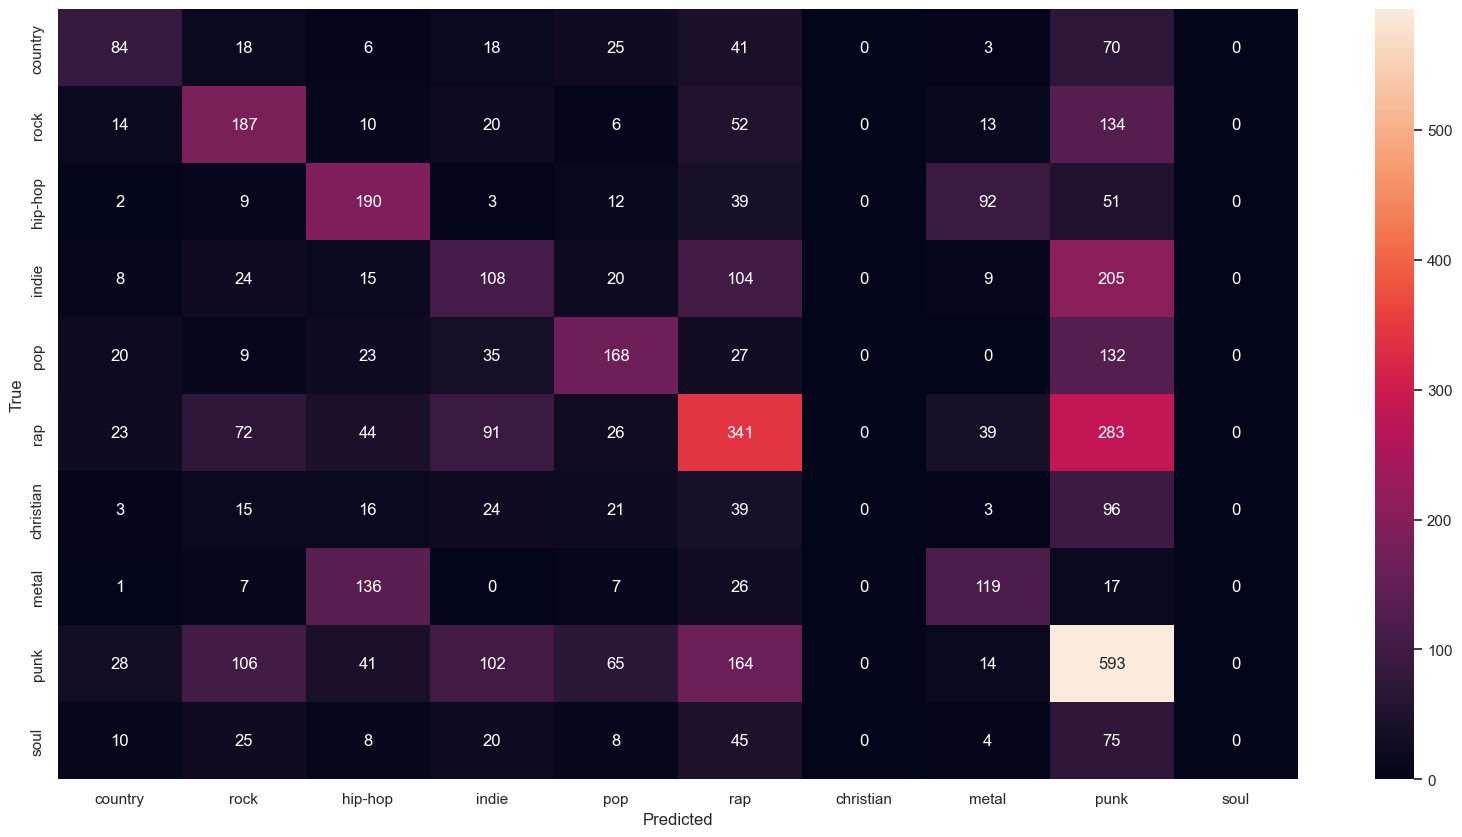

In [34]:
#initializer ='random_uniform'
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, input_length=200))
model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1024, kernel_initializer='glorot_uniform', activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense( len(categories), activation=tf.nn.sigmoid))
model.add(keras.layers.Softmax())
model.summary()


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_k_train, y_k_train, epochs=500, batch_size=512, validation_data=(x_k_test, y_k_test), verbose=1, callbacks=[callback])


y_prediction = model.predict(x_k_test)
y_pred_classes = np.argmax(y_prediction, axis=1)
y_test_classes = np.argmax(y_k_test.to_numpy(), axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')

print(classification_report(y_test_classes, y_pred_classes, target_names=categories))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Help of pre-trained embeddings

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LyricsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long).to(device)
        return lyrics, label_index
    
class LyricsTextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_model, embedding_dim, categories, model_type = "fc", embedding_type = "sentence-transformer"):
        super(LyricsTextClassificationModel, self).__init__()
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_dim
        self.model_type = model_type
        self.embedding_type = embedding_type

        if model_type == "embedding_then_one_layer":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, len(categories))
            )
        elif model_type == "convolution":
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(18944, 1024),  # Replace ? with the appropriate input size after flattening
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories))
            )
        elif model_type == "convolution-batch-normalization":
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(18944, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories)),
                nn.Sigmoid()
            )
        elif model_type == "fc":

    
    def forward(self, input_ids):
        if self.embedding_type == "sentence-transformer":
            outputs = self.embedding_model.encode(input_ids, convert_to_tensor=True)
        elif self.embedding_type == "transformer":
            outputs = self.embedding_model(input_ids)
        logits = self.sequential(outputs)
        return logits
    
def train_and_evaluate(model, model_name, num_epochs, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1):
    df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

    scaler = GradScaler(enabled=use_fp16)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()

            with autocast(enabled=use_fp16):
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            train_loss += loss.item()

        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        print(f"Model {model_name}: Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [model_name], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)
    # Save the dataframe as a CSV file for each model
    df.to_csv(f'{model_name}_history.csv', index=False)
    df = df.iloc[0:0]

    #for each model to be tested, use the following code to get the confusion matrix and classification report
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return df

batchsize = 512
train_dataset = LyricsDataset(train_features, train_targets)
test_dataset = LyricsDataset(test_features, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Using lyrics-bert with one additional fully connected layer

In [35]:
model_name = 'embedding-then-one-layer'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) 
embedding_then_one_layer_model = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, embedding_type="sentence-transformer", model_type="embedding_then_one_layer")
embedding_then_one_layer_model.to(device)
print(model_summary(embedding_then_one_layer_model))
history = train_and_evaluate(embedding_then_one_layer_model, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


KeyboardInterrupt: 

Model 1 - Epoch 1 Train Accuracy: 0.4373 Test Accuracy: 0.4088 F1 Score: 0.3901 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.4209 Eval Time/Step: 0.3586
Model 1 - Epoch 2 Train Accuracy: 0.4456 Test Accuracy: 0.4035 F1 Score: 0.3850 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.3269 Eval Time/Step: 0.3432
Model 1 - Epoch 3 Train Accuracy: 0.4428 Test Accuracy: 0.4067 F1 Score: 0.3880 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.3171 Eval Time/Step: 0.3780
Model 1 - Epoch 4 Train Accuracy: 0.4467 Test Accuracy: 0.4073 F1 Score: 0.3891 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.3628 Eval Time/Step: 0.2894
Model 1 - Epoch 5 Train Accuracy: 0.4472 Test Accuracy: 0.4067 F1 Score: 0.3876 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.3630 Eval Time/Step: 0.2907
Model 1 - Epoch 6 Train Accuracy: 0.4459 Test Accuracy: 0.4050 F1 Score: 0.3861 Train Loss: 0.0031 Test Loss: 0.0035 Train Time/Step: 0.3612 Eval Time/Step: 0.2880
Model 1 - Epoch 

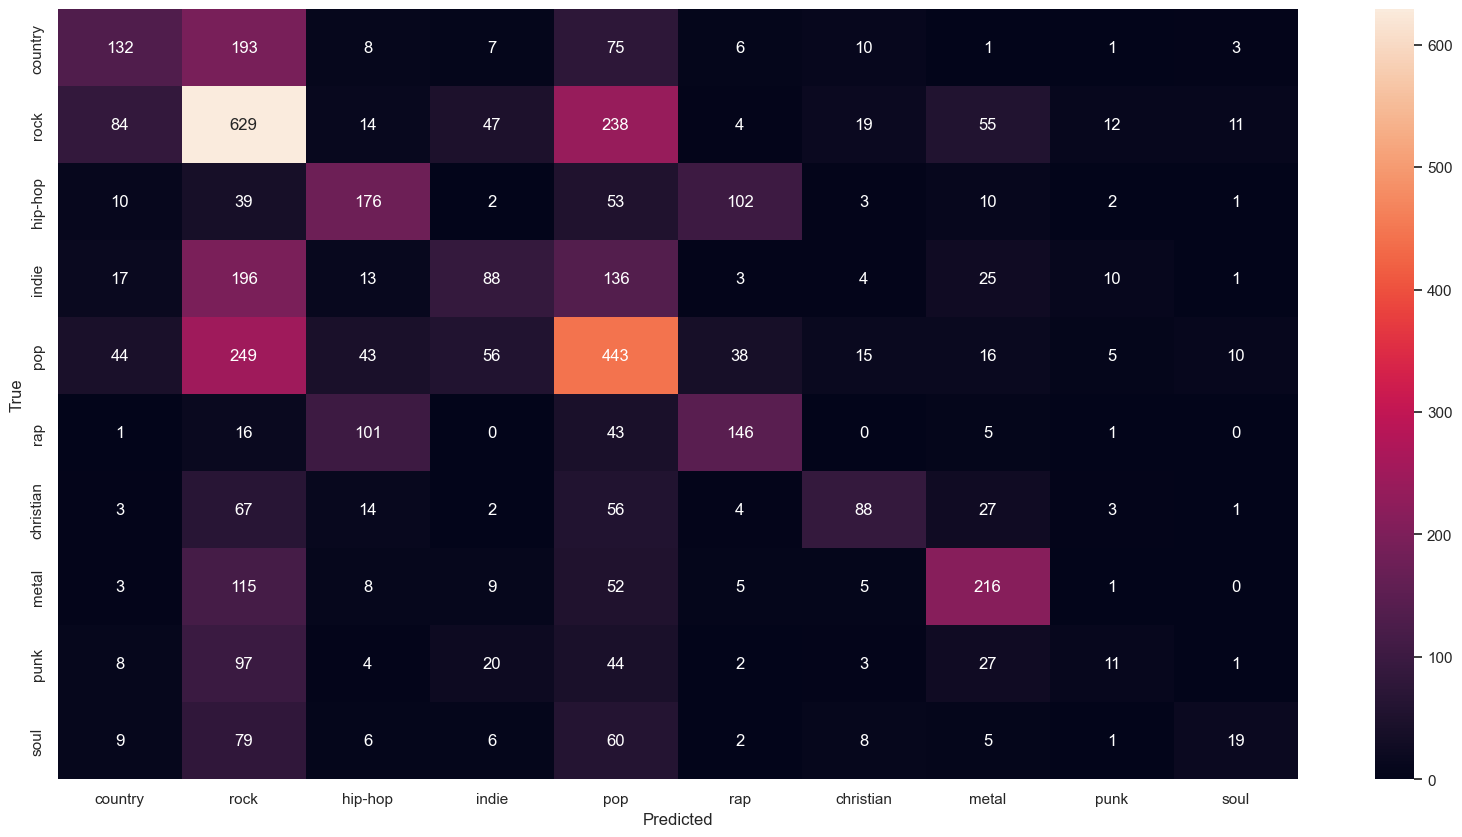

In [38]:
train_and_evaluate(embedding_then_one_layer, "embedding-then-one-layer", 10, criterion, optimizers[0], train_dataloader, test_dataloader, label_names)

# Using lyrics-bert and convolution (doesn't make too much sense)

Model summary:
---------------------------
Total parameters: 40397342
None
Model 1 - Epoch 1 Train Accuracy: 0.1942 Test Accuracy: 0.2337 F1 Score: 0.0885 Train Loss: 0.0057 Test Loss: 0.0045 Train Time/Step: 0.8706 Eval Time/Step: 0.9194
Model 1 - Epoch 2 Train Accuracy: 0.2361 Test Accuracy: 0.2337 F1 Score: 0.0885 Train Loss: 0.0043 Test Loss: 0.0044 Train Time/Step: 0.6873 Eval Time/Step: 0.5118
Model 1 - Epoch 3 Train Accuracy: 0.2414 Test Accuracy: 0.2354 F1 Score: 0.0970 Train Loss: 0.0042 Test Loss: 0.0043 Train Time/Step: 0.6227 Eval Time/Step: 0.3504
Model 1 - Epoch 4 Train Accuracy: 0.2727 Test Accuracy: 0.2870 F1 Score: 0.1706 Train Loss: 0.0041 Test Loss: 0.0041 Train Time/Step: 0.3581 Eval Time/Step: 0.3748
Model 1 - Epoch 5 Train Accuracy: 0.2937 Test Accuracy: 0.2895 F1 Score: 0.1669 Train Loss: 0.0039 Test Loss: 0.0040 Train Time/Step: 0.6733 Eval Time/Step: 0.5541
Model 1 - Epoch 6 Train Accuracy: 0.3119 Test Accuracy: 0.3082 F1 Score: 0.2157 Train Loss: 0.0038 Test L

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     country       0.75      0.04      0.08       436
        rock       0.33      0.66      0.44      1113
     hip-hop       0.46      0.55      0.50       398
       indie       0.00      0.00      0.00       493
         pop       0.33      0.49      0.39       919
         rap       0.57      0.32      0.41       313
   christian       0.80      0.14      0.23       265
       metal       0.49      0.50      0.50       414
        punk       0.00      0.00      0.00       217
        soul       0.00      0.00      0.00       195

    accuracy                           0.37      4763
   macro avg       0.37      0.27      0.26      4763
weighted avg       0.37      0.37      0.31      4763



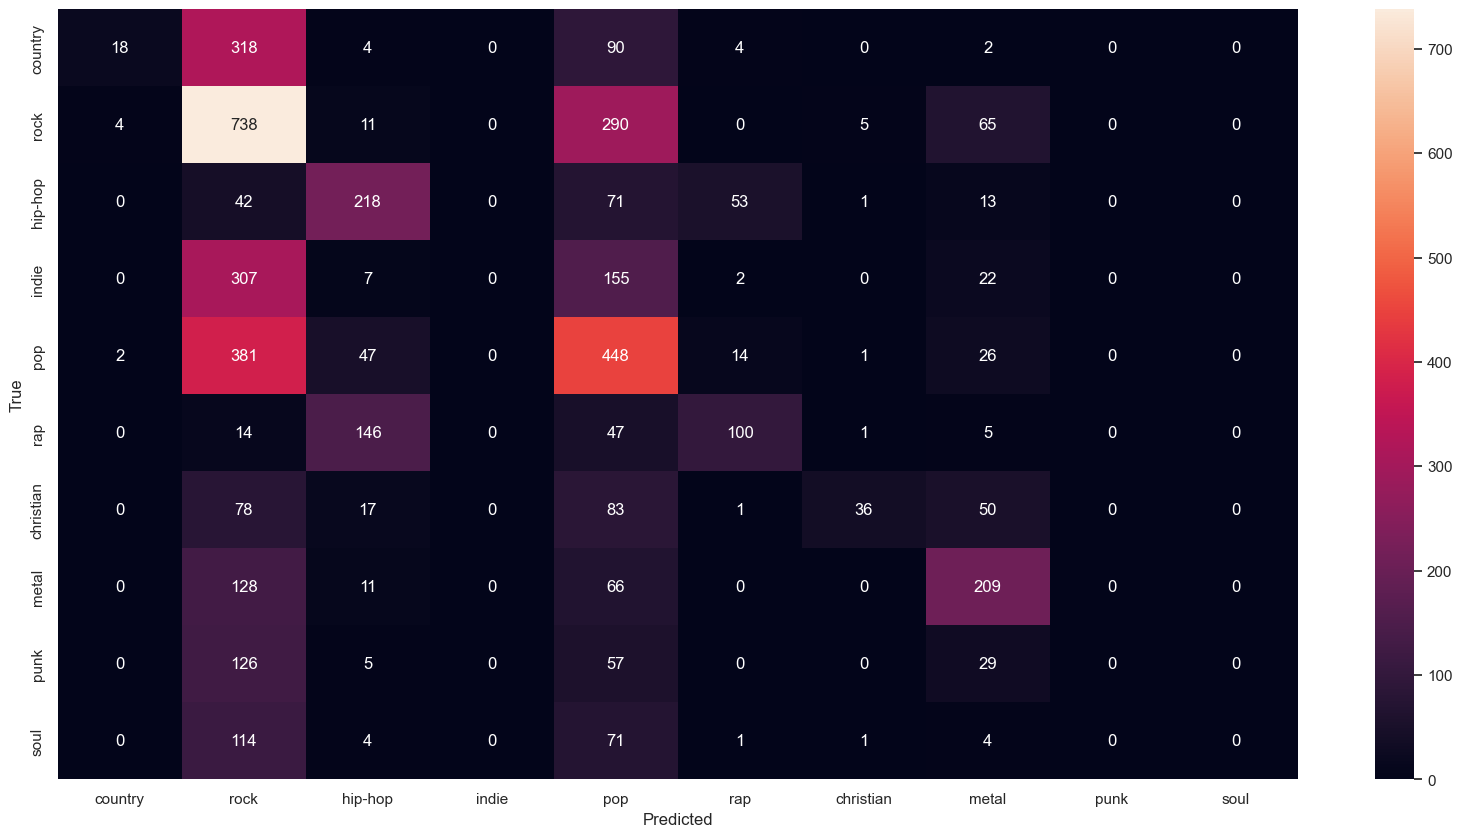

In [41]:
embedding_then_conv1d = EmbeddingThenConv1d(embedding_model)
embedding_then_conv1d.to(device)

models = [embedding_then_conv1d]
model_names = ['embedding-then-conv1d']
print(model_summary(embedding_then_conv1d))

criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

# Train your models
num_epochs = 10
batchsize = 512
# Create PyTorch dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Using Distilbert Base instead of lyrics-bert

In [13]:
embedding_then_conv1d = EmbeddingThenConv1d(SentenceTransformer("distilbert-base-uncased"))
embedding_then_conv1d.to(device)

models = [embedding_then_conv1d]
model_names = ['embedding-then-conv1d-distilbert-base-uncased']
print(model_summary(embedding_then_conv1d))

criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

num_epochs = 10
batchsize = 512
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

for model_idx, model in enumerate(models):
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()
        for inputs, labels in train_dataloader:
            optimizers[model_idx].zero_grad()
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_idx].step()
            train_loss += loss.item()
            
        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        print(f"Model {model_idx+1} - Epoch {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [f'model{model_idx+1}'], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)


    df.to_csv(f'{model_names[model_idx]}_history.csv', index=False)
    df = df.iloc[0:0]

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 116444426
None
Model 1 - Epoch 1 Train Accuracy: 0.1775 Test Accuracy: 0.1997 F1 Score: 0.0844 Train Loss: 0.0108 Test Loss: 0.0044 Train Time/Step: 1.4060 Eval Time/Step: 1.2980
Model 1 - Epoch 2 Train Accuracy: 0.2403 Test Accuracy: 0.2645 F1 Score: 0.1584 Train Loss: 0.0042 Test Loss: 0.0043 Train Time/Step: 1.3877 Eval Time/Step: 1.2910
Model 1 - Epoch 3 Train Accuracy: 0.2741 Test Accuracy: 0.3107 F1 Score: 0.1961 Train Loss: 0.0040 Test Loss: 0.0040 Train Time/Step: 1.3875 Eval Time/Step: 1.2930
Model 1 - Epoch 4 Train Accuracy: 0.3099 Test Accuracy: 0.3334 F1 Score: 0.2424 Train Loss: 0.0038 Test Loss: 0.0038 Train Time/Step: 1.3951 Eval Time/Step: 1.2689
Model 1 - Epoch 5 Train Accuracy: 0.3349 Test Accuracy: 0.3584 F1 Score: 0.2708 Train Loss: 0.0036 Test Loss: 0.0037 Train Time/Step: 1.3882 Eval Time/Step: 1.3034
Model 1 - Epoch 6 Train Accuracy: 0.3524 Test Accuracy: 0.3955 F1 Score: 0.3312 Train Loss: 0.0035 Test 

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'label_names' is not defined

# Using batch normalization, learning scheduler

Model summary:
---------------------------
Total parameters: 40399646
None
Model 1 - Epoch 1 Train Accuracy: 0.2979 Test Accuracy: 0.2696 F1 Score: 0.2307 Train Loss: 0.0041 Test Loss: 0.0045 Train Time/Step: 0.5528 Eval Time/Step: 0.2819
Model 1 - Epoch 2 Train Accuracy: 0.3815 Test Accuracy: 0.3748 F1 Score: 0.3366 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.3102 Eval Time/Step: 0.2841
Model 1 - Epoch 3 Train Accuracy: 0.4102 Test Accuracy: 0.3676 F1 Score: 0.3320 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.3139 Eval Time/Step: 0.2881
Model 1 - Epoch 4 Train Accuracy: 0.4458 Test Accuracy: 0.3796 F1 Score: 0.3445 Train Loss: 0.0037 Test Loss: 0.0041 Train Time/Step: 0.3353 Eval Time/Step: 0.2790
Model 1 - Epoch 5 Train Accuracy: 0.4873 Test Accuracy: 0.3918 F1 Score: 0.3506 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.3099 Eval Time/Step: 0.2822
Model 1 - Epoch 6 Train Accuracy: 0.5273 Test Accuracy: 0.3865 F1 Score: 0.3474 Train Loss: 0.0035 Test L

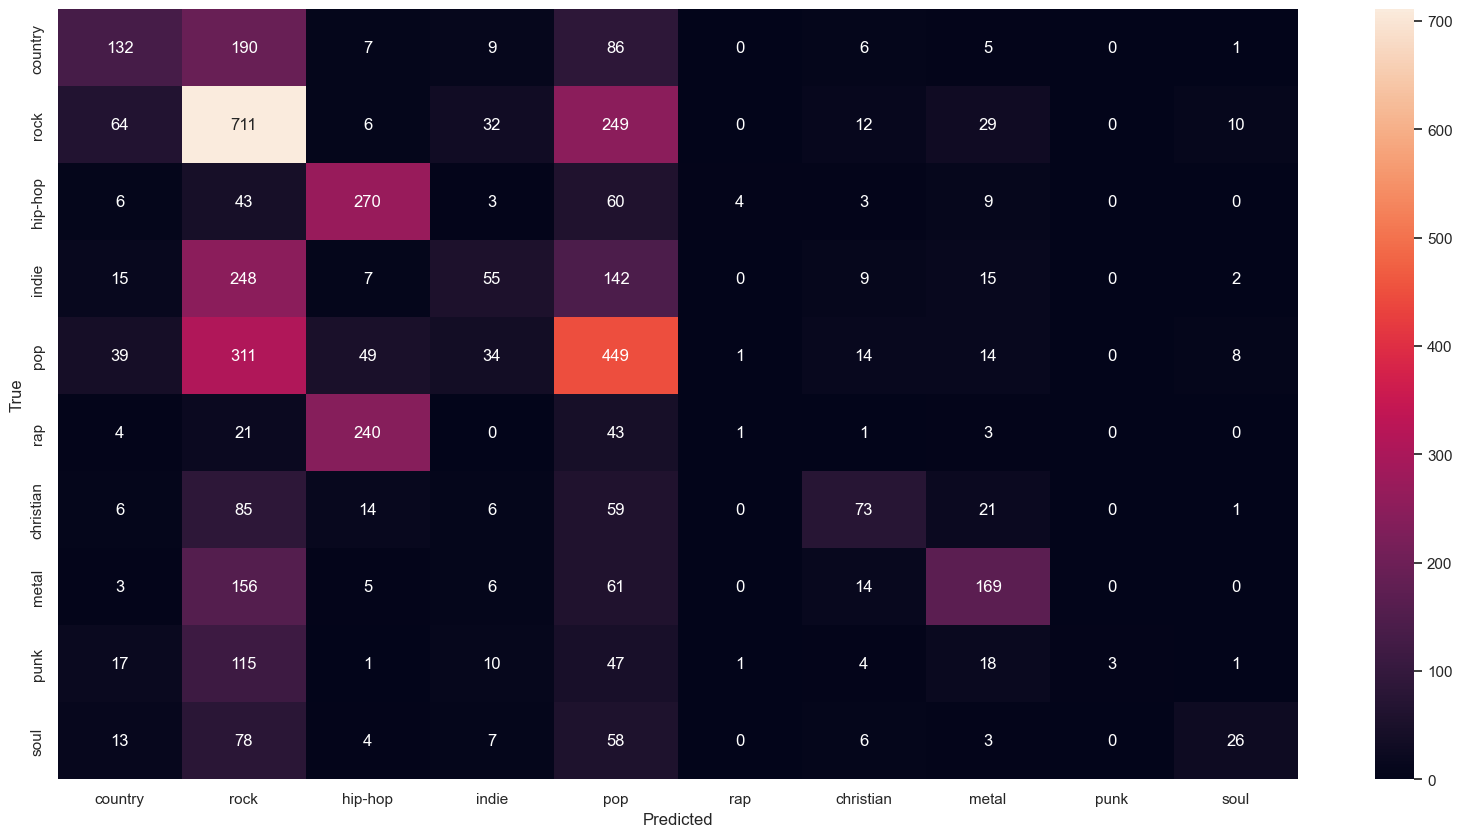

In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

embedding_then_conv1d_bn = EmbeddingThenConv1dBn(embedding_model)
embedding_then_conv1d_bn.to(device)

models = [embedding_then_conv1d_bn]
model_names = ['embedding-then-conv1d-bn']
print(model_summary(embedding_then_conv1d_bn))

learning_rate = 0.001
batch_size = 64

optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in models]
schedulers = [ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) for optimizer in optimizers]

class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(train_targets),
                                            y = train_targets  
                                        )
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

num_epochs = 10
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

for model_idx, model in enumerate(models):
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()
        for inputs, labels in train_dataloader:
            optimizers[model_idx].zero_grad()
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_idx].step()
            train_loss += loss.item()
            
        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        
        #scheduler
        schedulers[model_idx].step(test_loss)
        
        print(f"Model {model_idx+1} - Epoch {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [f'model{model_idx+1}'], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)


    df.to_csv(f'{model_names[model_idx]}_history.csv', index=False)
    df = df.iloc[0:0]
    
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

embedding_then_fc_bn = EmbeddingThenFcBn(embedding_model)
embedding_then_fc_bn.to(device)

models = [embedding_then_fc_bn]
model_names = ['embedding_then_fc_bn']
print(model_summary(embedding_then_fc_bn))

learning_rate = 0.001
batch_size = 64

optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in models]
schedulers = [ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) for optimizer in optimizers]

class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(train_targets),
                                            y = train_targets  
                                        )
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

num_epochs = 50

train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

def partition_assign(a, n):
    idx = np.argpartition(a,-n,axis=1)[:,-n:]
    out = np.zeros(a.shape, dtype=int)
    np.put_along_axis(out,idx,1,axis=1)
    return out

for model_idx, model in enumerate(models):
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()
        for inputs, labels in train_dataloader:
            optimizers[model_idx].zero_grad()
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_idx].step()
            train_loss += loss.item()
            
        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        
        #scheduler
        schedulers[model_idx].step(test_loss)
        
        print(f"Model {model_idx+1} - Epoch {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [f'model{model_idx+1}'], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)


    df.to_csv(f'{model_names[model_idx]}_history.csv', index=False)
    df = df.iloc[0:0]

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Model summary:
---------------------------
Total parameters: 65550622
None
Model 1 - Epoch 1 Train Accuracy: 0.3015 Test Accuracy: 0.3361 F1 Score: 0.2659 Train Loss: 0.0041 Test Loss: 0.0042 Train Time/Step: 0.6688 Eval Time/Step: 0.3709
Model 1 - Epoch 2 Train Accuracy: 0.3578 Test Accuracy: 0.3529 F1 Score: 0.3337 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.4388 Eval Time/Step: 0.3341
Model 1 - Epoch 3 Train Accuracy: 0.3927 Test Accuracy: 0.3584 F1 Score: 0.3304 Train Loss: 0.0037 Test Loss: 0.0041 Train Time/Step: 0.9041 Eval Time/Step: 0.7574
Model 1 - Epoch 4 Train Accuracy: 0.4220 Test Accuracy: 0.3662 F1 Score: 0.3357 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.6866 Eval Time/Step: 0.4232
Model 1 - Epoch 5 Train Accuracy: 0.4469 Test Accuracy: 0.3792 F1 Score: 0.3489 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.5253 Eval Time/Step: 0.4095
Model 1 - Epoch 6 Train Accuracy: 0.4911 Test Accuracy: 0.3811 F1 Score: 0.3456 Train Loss: 0.0035 Test L

KeyboardInterrupt: 

# Same with distilbert base

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

class EmbeddingThenFcBn(torch.nn.Module):
    def __init__(self, embedding_model):
        super(EmbeddingThenFcBn, self).__init__()
        self.embedding_model = embedding_model
        self.bn1 = nn.BatchNorm1d(18944)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc0 = nn.Linear(768, 18944)
        self.fc1 = nn.Linear(18944, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(2048, len(categories))
    
    def forward(self, x):
        x = self.embedding_model.encode(x, convert_to_tensor=True)
        x = F.relu(self.fc0(x))
        x = self.bn1(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        return x

embedding_then_fc_bn = EmbeddingThenFcBn(SentenceTransformer("distilbert-base-uncased"))
embedding_then_fc_bn.to(device)

models = [embedding_then_fc_bn]
model_names = ['embedding_then_fc_bn-distilbert-base-uncased']
print(model_summary(embedding_then_fc_bn))

learning_rate = 0.001
batch_size = 64

optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in models]
schedulers = [ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) for optimizer in optimizers]

class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(train_targets),
                                            y = train_targets  
                                        )
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

num_epochs = 50

train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

def partition_assign(a, n):
    idx = np.argpartition(a,-n,axis=1)[:,-n:]
    out = np.zeros(a.shape, dtype=int)
    np.put_along_axis(out,idx,1,axis=1)
    return out

for model_idx, model in enumerate(models):
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()
        for inputs, labels in train_dataloader:
            optimizers[model_idx].zero_grad()
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_idx].step()
            train_loss += loss.item()
            
        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        
        #scheduler
        schedulers[model_idx].step(test_loss)
        
        print(f"Model {model_idx+1} - Epoch {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [f'model{model_idx+1}'], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)


    df.to_csv(f'{model_names[model_idx]}_history.csv', index=False)
    df = df.iloc[0:0]

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 119792650
None
Model 1 - Epoch 1 Train Accuracy: 0.3494 Test Accuracy: 0.3796 F1 Score: 0.3636 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 1.3155 Eval Time/Step: 1.2395
Model 1 - Epoch 2 Train Accuracy: 0.3912 Test Accuracy: 0.3504 F1 Score: 0.3202 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 1.3378 Eval Time/Step: 1.2344
Model 1 - Epoch 3 Train Accuracy: 0.4017 Test Accuracy: 0.3420 F1 Score: 0.3108 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 1.3459 Eval Time/Step: 1.2434
Model 1 - Epoch 4 Train Accuracy: 0.4162 Test Accuracy: 0.3431 F1 Score: 0.3061 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 1.3498 Eval Time/Step: 1.2488
Model 1 - Epoch 5 Train Accuracy: 0.4208 Test Accuracy: 0.3781 F1 Score: 0.3424 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 1.3450 Eval Time/Step: 1.2459
Model 1 - Epoch 6 Train Accuracy: 0.4405 Test Accuracy: 0.4310 F1 Score: 0.3906 Train Loss: 0.0036 Test 

KeyboardInterrupt: 

# Using a text data augmentor for augmenting the lyrics

In [22]:
import nlpaug.augmenter.word as naw
import random
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel

batch_size = 64

class LyricsDataset(Dataset):
    def __init__(self, data, labels, augment=False, augmentation_rate=0.1):
        self.data = data
        self.labels = labels
        self.augment = augment
        self.augmentation_rate = augmentation_rate
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
        self.augmenter = naw.SynonymAug(aug_src='wordnet')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long).to(device)

        if self.augment:
            lyrics = self.augmenter.augment(lyrics)
            
        return lyrics, label_index

class EmbeddingThenFcBn(torch.nn.Module):
    def __init__(self):
        super(EmbeddingThenFcBn, self).__init__()

        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        self.fc2 = nn.Linear(768, len(categories))
    
    def forward(self, x):
        x = self.tokenizer(x, return_tensors='tf')
        x = self.model(x)
        x = torch.sigmoid(self.fc2(x))
        return x
embedding_then_fc_bn = EmbeddingThenFcBn()
embedding_then_fc_bn.to(device)

models = [embedding_then_fc_bn]
model_names = ['embedding_then_fc_bn-distilbert-base-uncased']
print(model_summary(embedding_then_fc_bn))

learning_rate = 0.001

optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in models]
schedulers = [ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) for optimizer in optimizers]

class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(train_targets),
                                            y = train_targets  
                                        )
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

num_epochs = 25
batchsize = 4

train_dataset = LyricsDataset(train_features, train_targets, augment=True, augmentation_rate=0.1)
test_dataset = LyricsDataset(test_features, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

def partition_assign(a, n):
    idx = np.argpartition(a,-n,axis=1)[:,-n:]
    out = np.zeros(a.shape, dtype=int)
    np.put_along_axis(out,idx,1,axis=1)
    return out

for model_idx, model in enumerate(models):
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()
        for inputs, labels in train_dataloader:
            optimizers[model_idx].zero_grad()
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_idx].step()
            train_loss += loss.item()
            break
            
        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        
        #scheduler
        schedulers[model_idx].step(test_loss)
        
        print(f"Model {model_idx+1} - Epoch {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [f'model{model_idx+1}'], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)


    df.to_csv(f'{model_names[model_idx]}_history.csv', index=False)
    df = df.iloc[0:0]

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data

Model summary:
---------------------------
Total parameters: 7690
None


[nltk_data] Error downloading 'averaged_perceptron_tagger' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-p
[nltk_data]     ages/packages/taggers/averaged_perceptron_tagger.zip>:
[nltk_data]     <urlopen error [Errno -3] Temporary failure in name
[nltk_data]     resolution>


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle[0m

  Searched in:
    - '/home/bruno/nltk_data'
    - '/home/bruno/anaconda3/envs/p5/nltk_data'
    - '/home/bruno/anaconda3/envs/p5/share/nltk_data'
    - '/home/bruno/anaconda3/envs/p5/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [7]:
import torch
import torch.nn as nn
import lightgbm as lgb

Model summary:
---------------------------
Total parameters: 20986644


c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 19052, number of used features: 300
[LightGBM] [Info] Start training from score -2.393287
[LightGBM] [Info] Start training from score -1.438439
[LightGBM] [Info] Start training from score -2.443371
[LightGBM] [Info] Start training from score -2.278830
[LightGBM] [Info] Start training from score -1.631837
[LightGBM] [Info] Start training from score -2.656744
[LightGBM] [Info] Start training from score -2.943180
[LightGBM] [Info] Start training from score -2.524522
[LightGBM] [Info] Start training from score -3.092198
[LightGBM] [Info] Start training from score -3.266001
[1]	valid_0's multi_logloss: 2.10195
Training until validation scores don't improve for 25 rounds
[2]	valid_0's multi_logloss: 2.06839
[3]	valid_0's multi_logloss: 2.

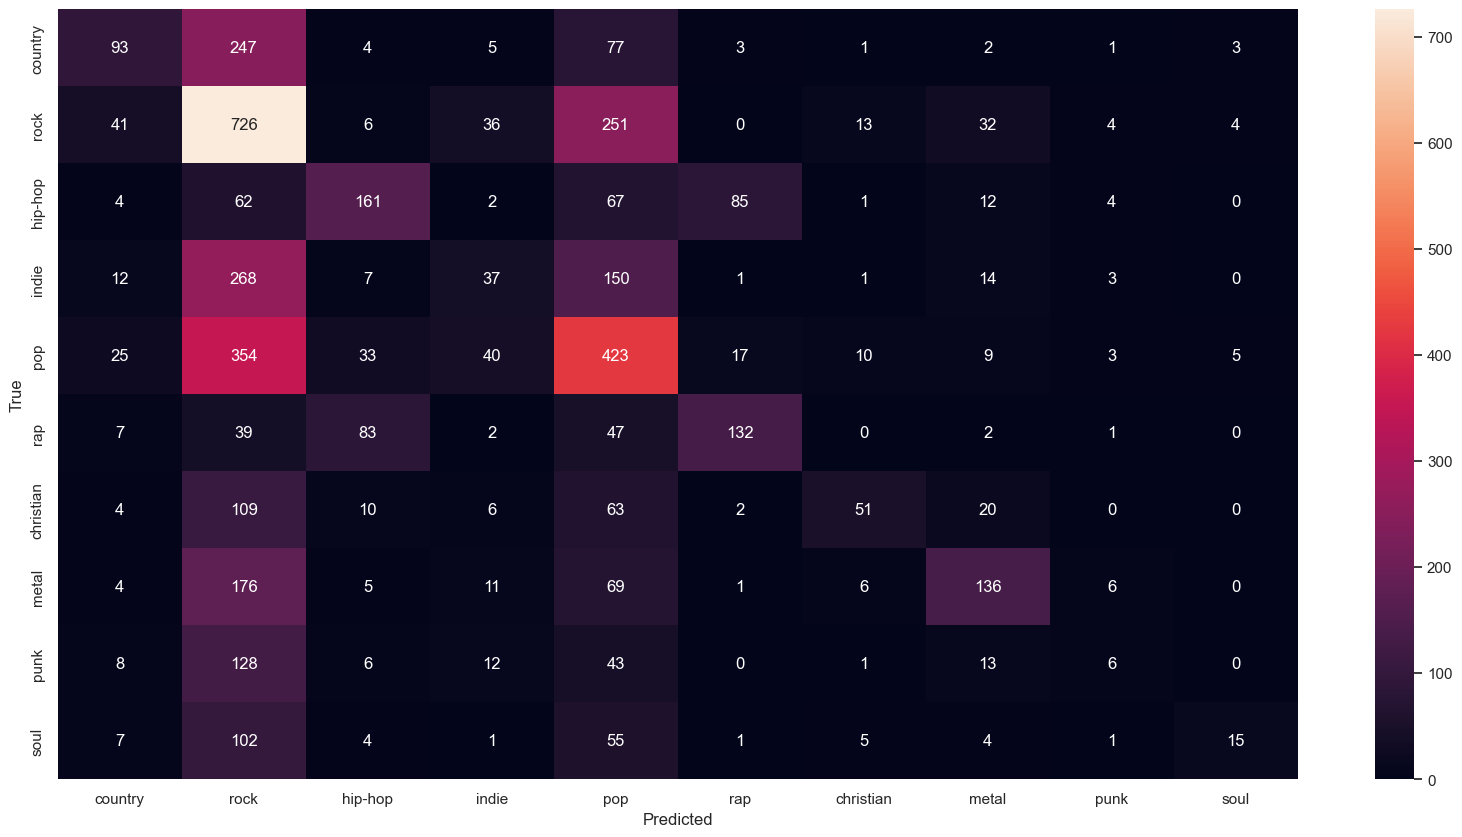

In [10]:
class BertFeatureExtractor(torch.nn.Module):
    def __init__(self, embedding_model):
        super(BertFeatureExtractor, self).__init__()
        self.embedding_model = embedding_model
    
    def forward(self, x):
        x = self.embedding_model.encode(x, convert_to_tensor=True)
        return x

# Initialize BERT feature extractor
bert_extractor = BertFeatureExtractor(embedding_model)
bert_extractor.to(device)
model_summary(bert_extractor)

train_features = []
train_targets = []
for inputs, labels in train_dataloader:
    outputs = bert_extractor(inputs)
    train_features.append(outputs.detach().cpu().numpy())
    train_targets.append(labels.detach().cpu().numpy())
train_features = np.vstack(train_features)
train_targets = np.array([item for sublist in train_targets for item in sublist])

# Generate features for training data
test_features = []
test_targets = []
for inputs, labels in test_dataloader:
    outputs = bert_extractor(inputs)
    test_features.append(outputs.detach().cpu().numpy())
    test_targets.append(labels.detach().cpu().numpy())
test_features = np.vstack(test_features)
test_targets = np.array([item for sublist in test_targets for item in sublist])

# Train LightGBM model on generated features
train_data = lgb.Dataset(train_features, label=train_targets)
test_data = lgb.Dataset(test_features, label=test_targets)
params = {'objective': 'multiclass', 'num_class': len(categories), 'metric': 'multi_logloss'}
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data], early_stopping_rounds=25)

# Evaluate LightGBM model on test data
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_targets, y_pred)
report = classification_report(test_targets, y_pred, target_names=categories)
print(report)
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
train_features

array([[ 0.13540943,  0.09441344, -0.11168075, ..., -0.07169322,
         0.10988794, -0.08393987],
       [-0.14612277,  0.02783801,  0.03427171, ...,  0.00329544,
        -0.18892527,  0.06321722],
       [ 0.10109213,  0.13315323,  0.05992852, ...,  0.00621317,
         0.1477386 ,  0.2368953 ],
       ...,
       [-0.05498765,  0.077382  ,  0.09948158, ...,  0.09934387,
        -0.02897785, -0.00661732],
       [ 0.15426223,  0.14590205,  0.00692275, ..., -0.02816135,
        -0.08139496, -0.00674643],
       [-0.08395427, -0.09034391,  0.0150704 , ..., -0.10142272,
        -0.10681746,  0.06146671]], dtype=float32)

In [15]:
from transformers import Trainer, TrainingArguments
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

class LyricsDataset(Dataset):
    def __init__(self, tokenizer, data, labels):
        self.tokenizer = tokenizer
        self.data = data
        self.labels = labels
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long)

        # Tokenize the lyrics
        tokenized_lyrics = self.tokenizer(lyrics, truncation=True, padding=False, return_tensors="pt")
        
        # Convert tokenized_lyrics to a dictionary and add the label_index
        tokenized_lyrics = {k: v.squeeze(0) for k, v in tokenized_lyrics.items()}
        tokenized_lyrics["labels"] = label_index

        return tokenized_lyrics

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model.to("cuda")
train_dataset = LyricsDataset(tokenizer, train_features, train_targets)
test_dataset = LyricsDataset(tokenizer, test_features, test_targets)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="../models/fine-tune/",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Define the accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).mean()}

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

AssertionError: Torch not compiled with CUDA enabled